In [1]:
import numpy as np
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, RickerSource, Receiver
from devito import clear_cache, set_log_level
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Model with fixed time step value
class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking.
    The critical dt is made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value."""
        return .1

# Verification

We compute the error between the numerical and reference solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the error for these parameters.

In [3]:
# Discretization order
orders = (2, 4, 6, 8, 10)
norder = len(orders)

# Domain sizes and gird spacing
shapes = ((201, 2.0), (161, 2.5), (101, 4.0))
dx = [2.0, 2.5, 4.0]
nshapes = len(shapes)

# Number of time steps
nt = 1501
# Time axis
time = np.linspace(0., 150., nt)
# Source peak frequency
f0 = .070

In [4]:
# Fine grid model
c0 = 1.500
model = ModelBench(vp=c0, origin=(0., 0.), spacing=(1.0, 1.0), shape=(401, 401), nbpml=40, dtype=np.float64)

In [5]:
# Source and receiver
src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.data[:] = src.data[:] / c0**2
# Define receiver geometry (spread across x, just below surface)
rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
rec.coordinates.data[:, 0] = 260.
rec.coordinates.data[:, 1] = 260.

# Reference solution for numerical convergence

In [6]:
solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=40)

ref_rec, ref_u, _ = solver.forward()

GNUCompiler: compiled /var/folders/mx/qs0dn9rx7zn6dz2zvwv7tkk00000gn/T/devito-1e775kz_/4fc72fedb6cab50578f4c65df25542e6a658b296.c [1.18 s]
Section section_1<1499,1> with OI=0.56 computed in 0.001 s [0.05 GFlops/s]
Section section_2<1499,1> with OI=0.77 computed in 0.058 s [0.00 GFlops/s]
Section main<1499,441,441> with OI=4.27 computed in 4.862 s [7.32 GFlops/s, 0.06 GPts/s]


# Analytical solution for comparison with the reference numerical solution

The analytical solution of the 2D acoustic wave-equation with a source pulse is defined as:

$$
G = \frac{1}{2\pi c^2}\frac{H(t-\frac{|r|}{c})}{\sqrt{t^2-\frac{r^2}{c^2}}}
$$

$$
r = \sqrt{x^2+y^2}
$$

where $H$ is the Heaviside function:


$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$


As we have a band-limited source to avoid dispersion, the analytical solution for a given time signature $q(t)$ is then
$$
Gc = \frac{1}{2\pi c^2}\frac{H(t-\frac{|r|}{c})}{\sqrt{t^2-\frac{r^2}{c^2}}} * q(t)
$$

We look at the analytical and numerical sol
ution at a single grid point. We ensure that this grid point is on-the-grid for all discretizations analyised in the further verification.

In [7]:
# Source position
sx = src.coordinates.data[0, 0]
sz = sx

# Poisiton of the comparison point
rx = sx + 60.
rz = sz + 60.


G    = time * 0.
# Radius
r    = np.sqrt((sx - rx) ** 2 + (sz - rz) ** 2)

# Analytical solution for a pulse
for it in range(nt): # Calculate Green's function
    if ((time[it] - r / c0) >= 0):
        G[it] = (1. / (2 * np.pi * c0 ** 2)) \
        * (1. / np.sqrt((time[it] ** 2) - (r ** 2 / (c0 ** 2))))
# Convolve with the time signature of the source
Gc   = np.convolve(G, src.data[:, 0] * .1 * c0**2)
Gc   = Gc[0:nt]

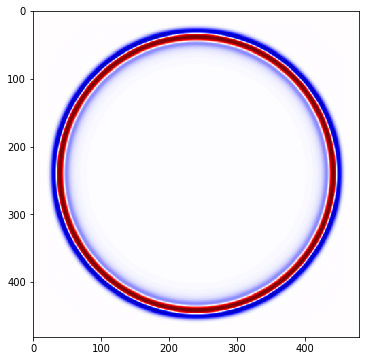

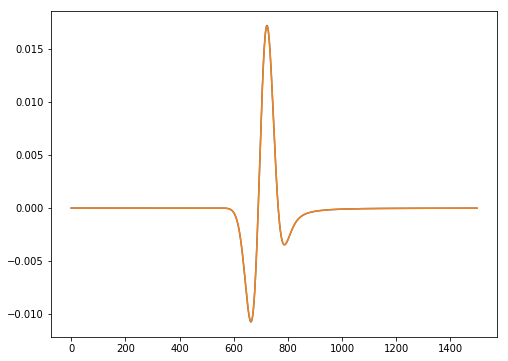

In [8]:
plt.figure()
plt.imshow(ref_u.data[1,:,:], vmin=-.01, vmax=.01, cmap="seismic")
plt.figure()
plt.plot(ref_rec.data[:-1, 0])
plt.plot(Gc[:-1])
plt.show()

In [9]:
np.linalg.norm(Gc[:-1] - ref_rec.data[:-1, 0], np.inf)

0.00015811624481343496

We have a correct refernce solution we can use for space discretization analysis

In [10]:
errorl2 = np.zeros((norder, nshapes))
timing = np.zeros((norder, nshapes))

set_log_level("ERROR")
ind_o = -1
for spc in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in shapes:
        ind_spc += 1
        clear_cache()
        model = ModelBench(vp=c0, origin=(0., 0.), spacing=(h, h), shape=(nn, nn),
                           nbpml=40, dtype=np.float64)
        src = RickerSource(name='src', grid=model.grid, f0=f0, time=time)
        src.coordinates.data[0, :] = 200.
        src.data[:] = src.data[:] / (c0*h)**2

        # Define receiver geometry (spread across x, just below surface)
        rec = Receiver(name='rec', grid=model.grid, ntime=nt, npoint=1)
        rec.coordinates.data[:, 0] = 260.
        rec.coordinates.data[:, 1] = 260.
        solver = AcousticWaveSolver(model, source=src, receiver=rec, time_order=2, space_order=spc)

        loc_rec, loc_u, summary = solver.forward()
        # minus error in time
        errorl2[ind_o, ind_spc] = np.linalg.norm(loc_rec.data[:] - ref_rec.data[:], np.inf)
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s seconds runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (201, 201) grid points the error is 0.00598463571118 for 0.546483 seconds runtime
starting space order 2 with (161, 161) grid points the error is 0.00928890233303 for 0.367981 seconds runtime
starting space order 2 with (101, 101) grid points the error is 0.0166404546387 for 0.272846 seconds runtime
starting space order 4 with (201, 201) grid points the error is 0.000359263760687 for 0.613835 seconds runtime
starting space order 4 with (161, 161) grid points the error is 0.000906708853458 for 0.416661 seconds runtime
starting space order 4 with (101, 101) grid points the error is 0.00534012866957 for 0.307681 seconds runtime
starting space order 6 with (201, 201) grid points the error is 3.62307126928e-05 for 0.413883 seconds runtime
starting space order 6 with (161, 161) grid points the error is 0.000136158181236 for 0.369511 seconds runtime
starting space order 6 with (101, 101) grid points the error is 0.00194734733602 for 0.247787 seconds runtime
startin

OpesciBench: Plotting ./TimeAccuracy.pdf 


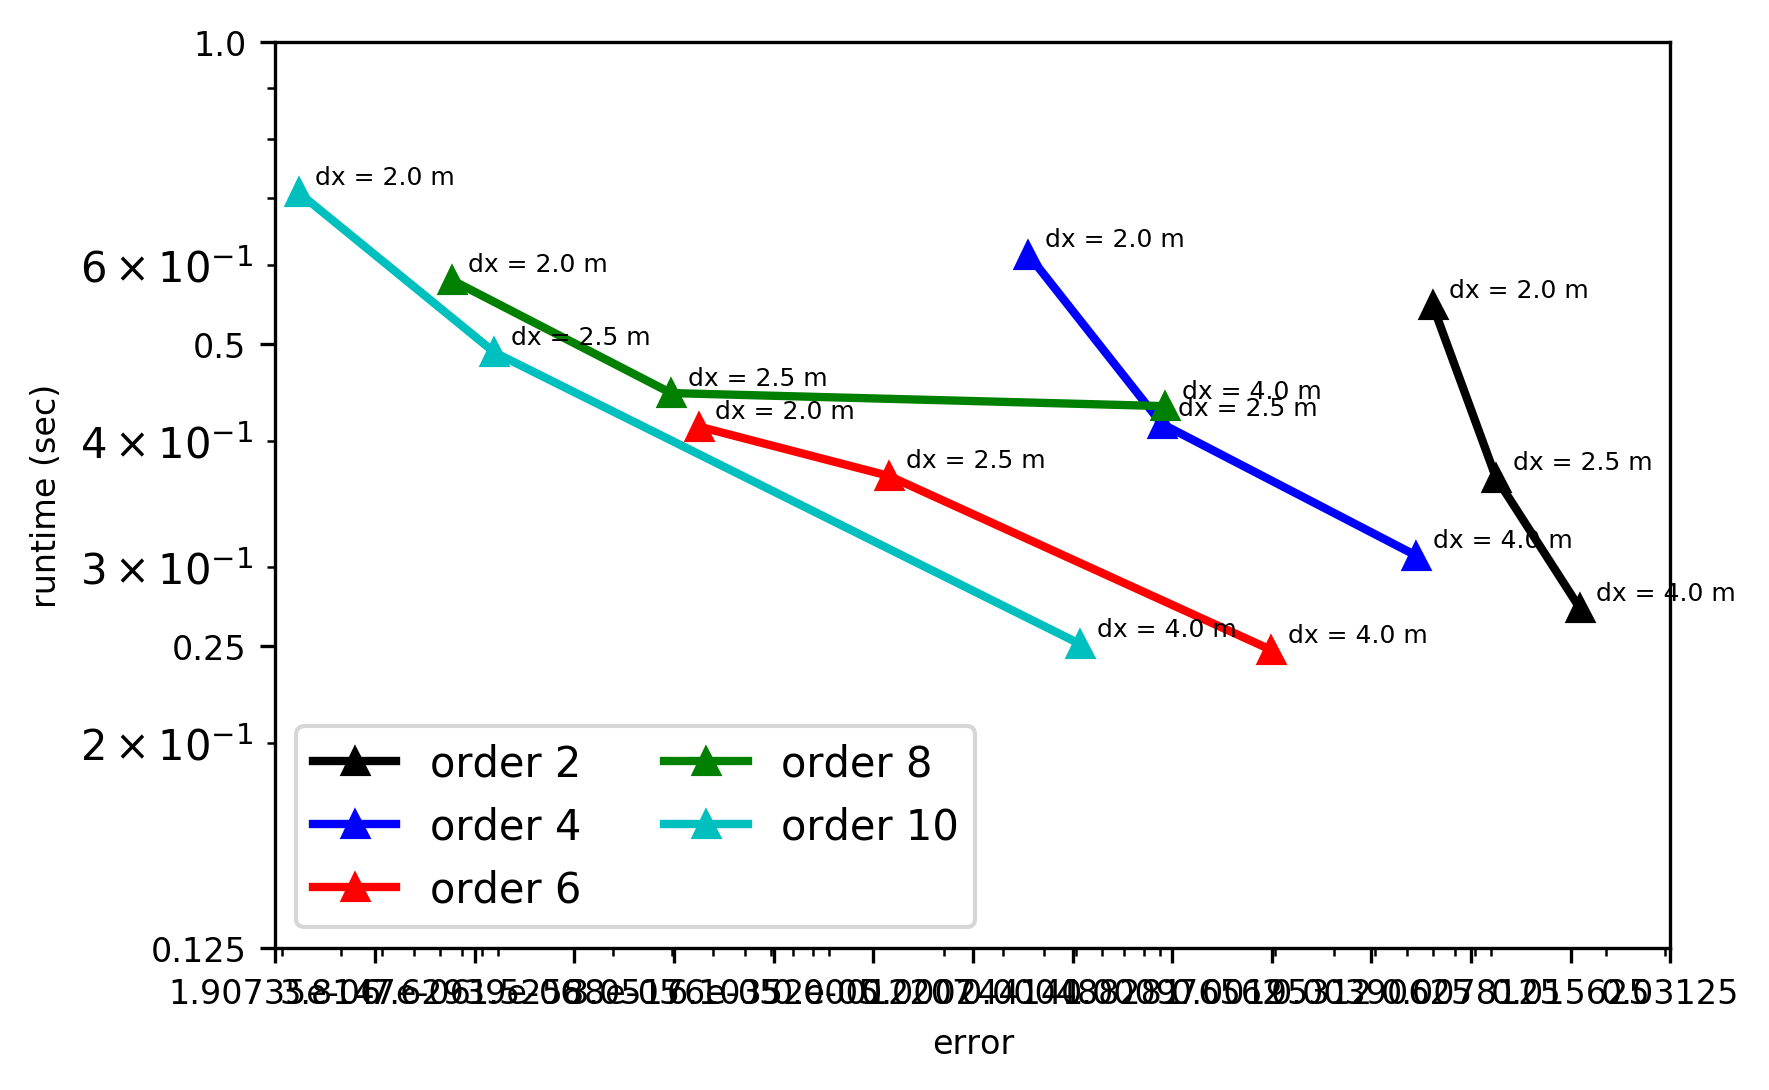

In [11]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

with LinePlotter(figname='TimeAccuracy.pdf', plotdir='./',  xlabel='error', ylabel='runtime (sec)') as plot:
    for i in range(0, 5):
        plot.add_line(list(errorl2[i, :]), list(timing[i, :]), label=('order %s' % orders[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx])
    
plt.show()

OpesciBench: Plotting ./Convergence.pdf 


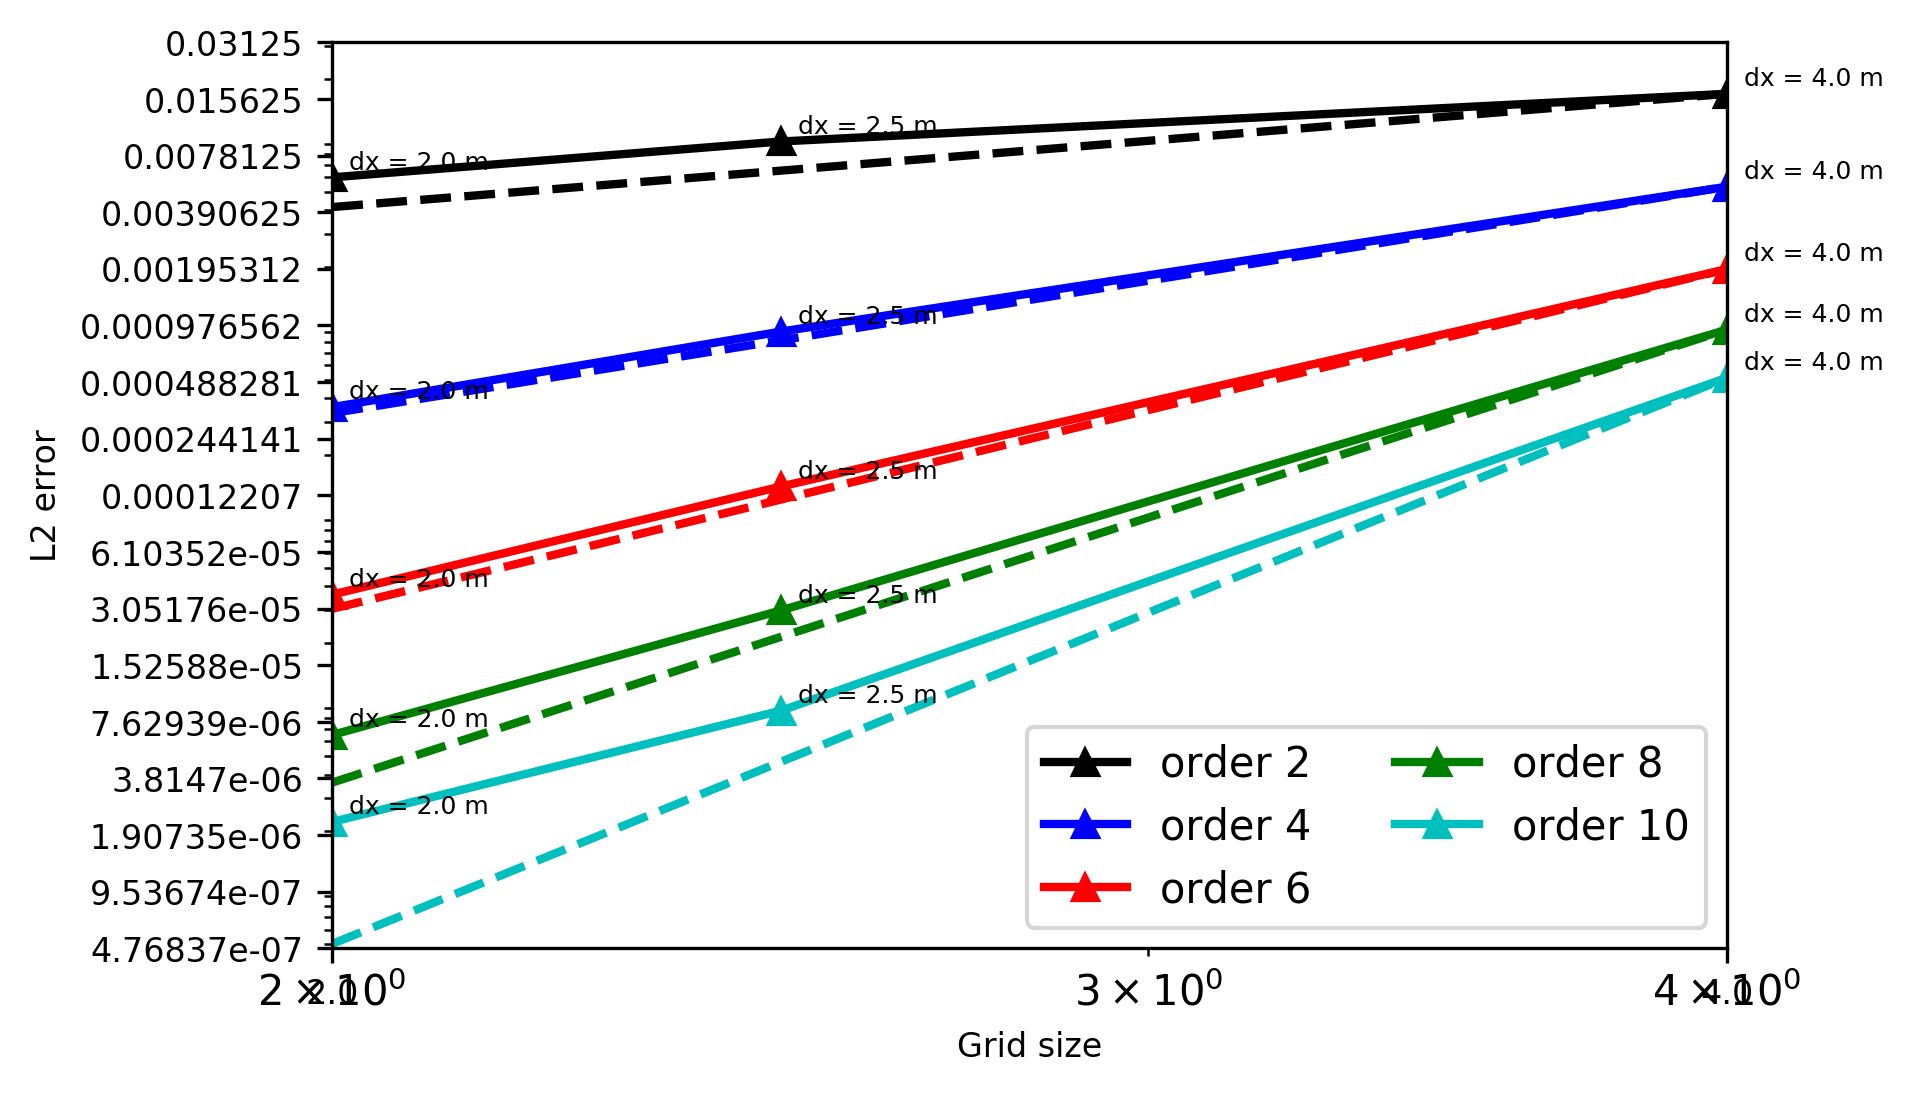

In [12]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='Convergence.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in dx]
        theory = [errorl2[i, 2]*th/theory[2] for th in theory]
        plot.add_line([sc for sc in dx], list(errorl2[i, :]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for sc in dx], style=stylel[i])
        plot.add_line([sc for  sc in dx], list(theory), style=style2[i])

plt.show()